In [1]:
!pip install torch scikit-learn matplotlib seaborn pandas

In [3]:
!git clone https://github.com/godotgodo/attention-analysis.git
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

df=pd.read_csv('attention-analysis/preprocessed_features.csv')

features = [
    'face_movement', 'body_movement', 'eye_openness_rate',
    'eye_direction_x', 'eye_direction_y', 'mouth_openness_rate',
    'yaw_angle', 'pitch_angle', 'roll_angle'
]
SEQ_LEN = 15

X_seq = []
y_seq = []

for i in range(len(df) - SEQ_LEN):
    seq = df[features].iloc[i:i+SEQ_LEN].values
    label = df['isAttentive'].iloc[i+SEQ_LEN-1]  # Sekans sonundaki frame'in label'i
    X_seq.append(seq)
    y_seq.append(int(label))

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

fatal: destination path 'attention-analysis' already exists and is not an empty directory.


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

class AttentionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(AttentionDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(AttentionDataset(X_test, y_test), batch_size=32)

# Model
class TransformerClassifier(nn.Module):
    def __init__(self, feature_dim, seq_len, num_classes=2):
        super().__init__()
        self.pos_encoding = nn.Parameter(torch.randn(seq_len, feature_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=feature_dim, nhead=3, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x + self.pos_encoding
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.classifier(x)

# Eğitim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerClassifier(feature_dim=X_seq.shape[2], seq_len=SEQ_LEN).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(20):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1:02d} - Loss: {total_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch 01 - Loss: 11.8758
Epoch 02 - Loss: 9.3624
Epoch 03 - Loss: 5.8923
Epoch 04 - Loss: 7.8265
Epoch 05 - Loss: 7.5283
Epoch 06 - Loss: 7.1059
Epoch 07 - Loss: 6.8221
Epoch 08 - Loss: 5.7604
Epoch 09 - Loss: 5.7275
Epoch 10 - Loss: 5.5461
Epoch 11 - Loss: 5.6676
Epoch 12 - Loss: 5.6207
Epoch 13 - Loss: 5.6297
Epoch 14 - Loss: 5.4622
Epoch 15 - Loss: 5.5376
Epoch 16 - Loss: 5.4867
Epoch 17 - Loss: 5.5368
Epoch 18 - Loss: 5.4594
Epoch 19 - Loss: 5.4294
Epoch 20 - Loss: 5.8739


              precision    recall  f1-score   support

           0       1.00      0.56      0.72        66
           1       0.99      1.00      0.99      2199

    accuracy                           0.99      2265
   macro avg       0.99      0.78      0.86      2265
weighted avg       0.99      0.99      0.99      2265



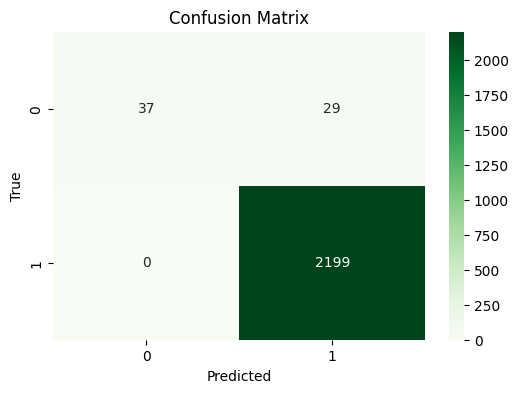

In [11]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_true.extend(yb.numpy())
        y_pred.extend(preds)

print(classification_report(y_true, y_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()